# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GroupShuffleSplit
import os
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, Subset
from google.colab import sheets
import scipy
from scipy.stats import chi2_contingency
from torchvision.transforms import Compose, Resize, Normalize
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import GroupShuffleSplit
import torch
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor, Resize, ToPILImage, GaussianBlur, RandomVerticalFlip
from torchvision import models
from transformers import (
    BertModel,
    BertTokenizer,
    T5Model,
    T5Tokenizer,
    ViTModel,
    ViTFeatureExtractor,
    CLIPProcessor,
    CLIPModel
)
from torch.utils.data import random_split
from google.colab import drive
import torch.optim as optim
from torchvision import models
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.models import resnet50
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.models import densenet121
from torch.optim.lr_scheduler import StepLR
from transformers import AutoImageProcessor, ViTHybridModel
from torchvision.transforms import ToPILImage
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score

# Loading Data

In [ ]:
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/DL Project/TabularData/original_mass_case_description_train_set.csv')
#preprocessed tensors with text and image per patient
train_path = "/content/drive/MyDrive/DL Project/TabularData/train_tensors.pt"
test_path = "/content/drive/MyDrive/DL Project/TabularData/test_tensors.pt"

# EDA (Clinical Reports)

In [ ]:
df_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

## Univariate Analysis

In [ ]:
#count each unique value in 'pathology'
df_train['pathology'].value_counts()
#extract counts and their category labels
num = list(df_train['pathology'].value_counts())
idx = list(df_train['pathology'].value_counts().index)

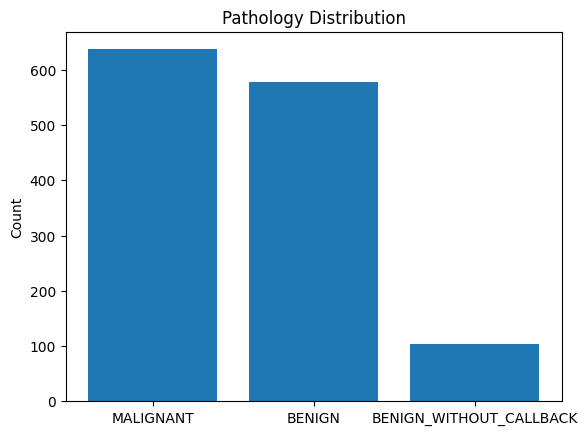

In [ ]:
plt.bar(idx, num)#plot category labels against their counts
plt.title('Pathology Distribution')
plt.ylabel('Count')
plt.savefig('PathologyDescription.png')
plt.show()

WITHOUT CALLBACK:

	•	Without Callback means that these findings did not prompt the radiologist to ask for further imaging or biopsies. In a typical mammography screening process, if a suspicious mass is detected, a callback may be requested for additional tests to ensure it is benign or malignant.
	•	For “BENIGN_WITHOUT_CALLBACK,” the mass was considered non-suspicious enough that no further action was needed.


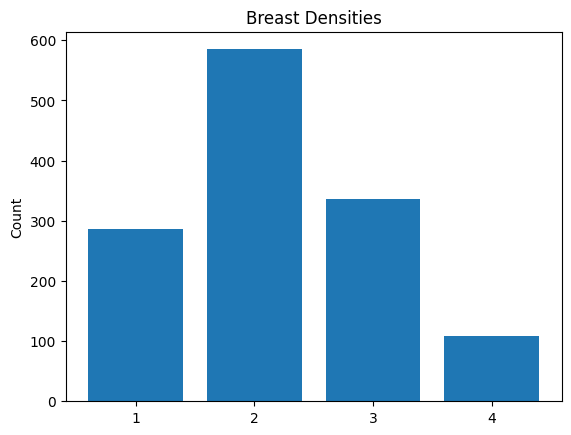

In [ ]:
#bar chart for the distribution of 'breast_density'
plt.bar(df_train['breast_density'].value_counts().index.astype(int), df_train['breast_density'].value_counts().astype(int))
plt.title('Breast Densities')
plt.xticks(ticks=[1,2, 3, 4])
plt.ylabel('Count')
plt.savefig('breast')
plt.show()


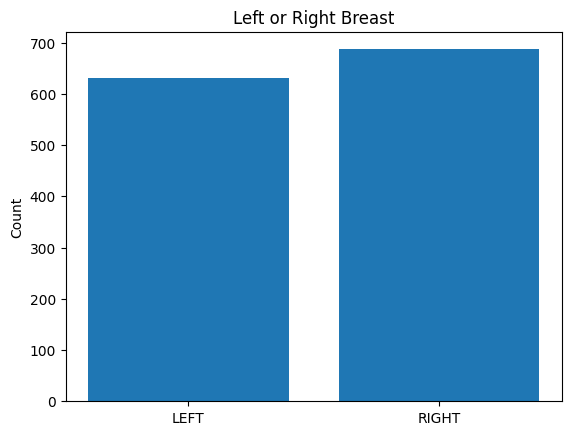

In [ ]:
#bar chart for the distribution of 'left or right breast'
plt.bar(df_train['left or right breast'].value_counts().index[::-1],
        df_train['left or right breast'].value_counts()[::-1])
plt.title('Left or Right Breast')
plt.ylabel('Count')
plt.show()

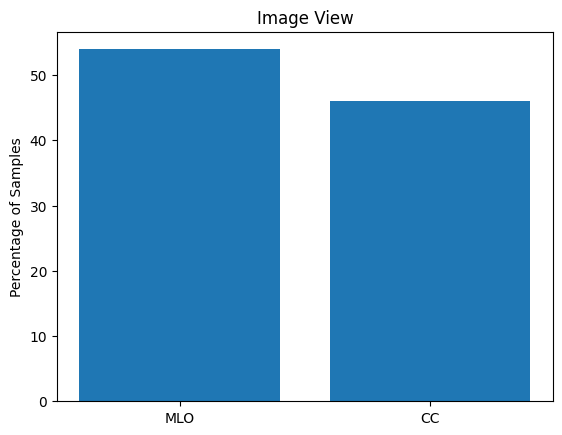

In [ ]:
import matplotlib.pyplot as plt
#calculate the frequency percentages for the 'image view' column
#normalize=True converts counts to proportions, and multiplying by 100 gives percentages
image_view_counts = df_train['image view'].value_counts(normalize=True) * 100
#bar plot for the percentage distribution of 'image view'
plt.bar(image_view_counts.index, image_view_counts)
plt.title('Image View')
plt.ylabel('Percentage of Samples')
plt.savefig('ImageView.png')
plt.show()

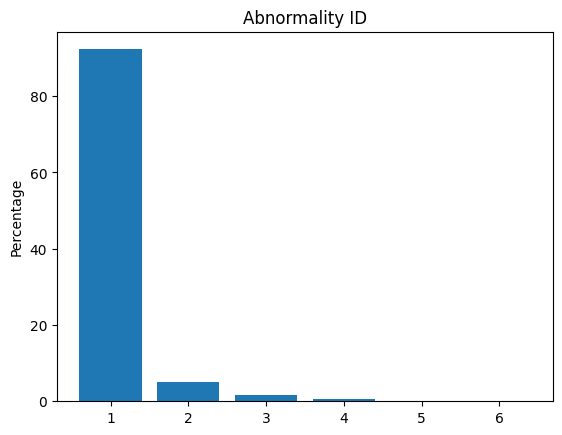

In [ ]:
#calculate the frequency percentages for 'abnormality id'
abnormality_id_counts = df_train['abnormality id'].value_counts(normalize=True) * 100
plt.bar(abnormality_id_counts.index, abnormality_id_counts)
plt.title('Abnormality ID')
plt.ylabel('Percentage')
plt.show()

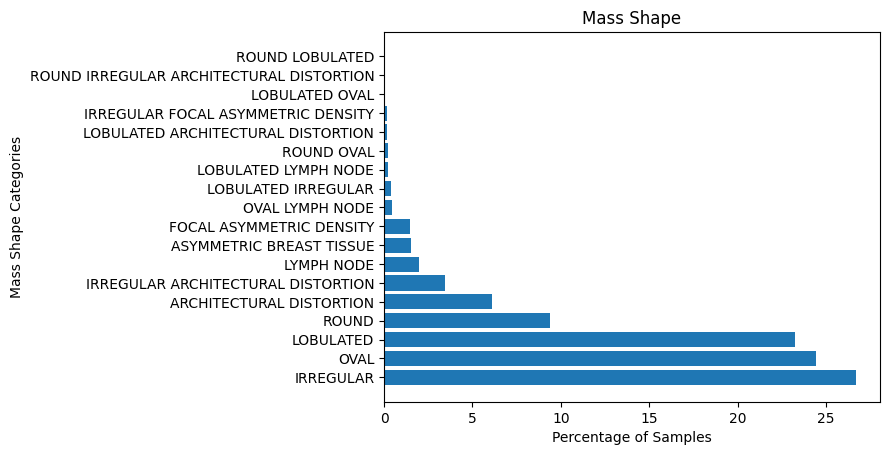

In [ ]:
#calculate the frequency percentages for 'mass shape' and sort in descending order
df_train['mass shape'] = df_train['mass shape'].str.replace('_', ' ').str.replace('-', ' ')
mass_shape_counts = df_train['mass shape'].value_counts(normalize=True) * 100
mass_shape_counts = mass_shape_counts.sort_values(ascending=False)

#horizontal bar plot for the distribution of 'mass shape'
plt.barh(mass_shape_counts.index, mass_shape_counts)
plt.title('Mass Shape')
plt.xlabel('Percentage of Samples')
plt.ylabel('Mass Shape Categories')
plt.savefig('MassShape.png')
plt.show()

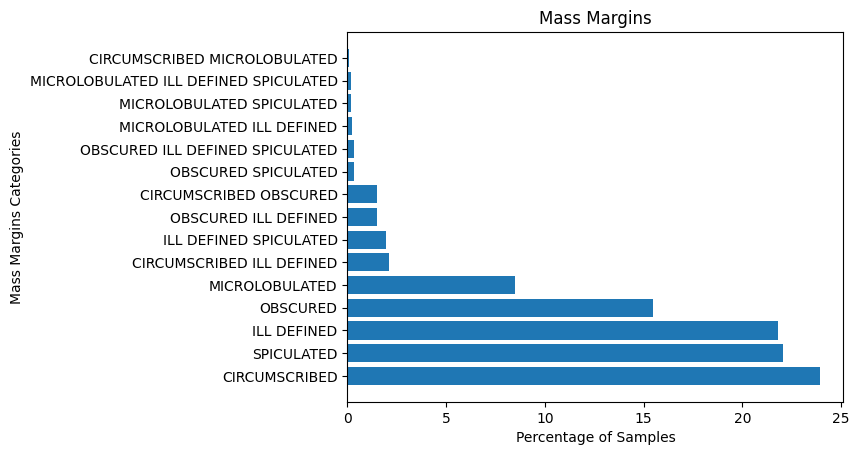

In [ ]:
#clean the 'mass margins' column by replacing underscores and hyphens with spaces
df_train['mass margins'] = df_train['mass margins'].str.replace('_', ' ').str.replace('-', ' ')

mass_margins_counts = df_train['mass margins'].value_counts(normalize=True) * 100
mass_margins_counts = mass_margins_counts.sort_values(ascending=False)

#horizontal bar plot for the percentage distribution of 'mass margins'
plt.barh(mass_margins_counts.index, mass_margins_counts)
plt.title('Mass Margins')
plt.xlabel('Percentage of Samples')
plt.ylabel('Mass Margins Categories')
plt.savefig('MassMargins.png')
plt.show()

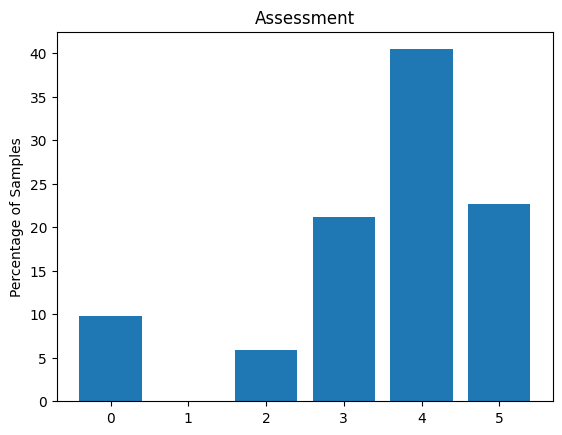

In [ ]:
#calculate the frequency percentages for 'assessment'
assessment_counts = df_train['assessment'].value_counts(normalize=True) * 100

#bar plot to visualize the percentage distribution of 'assessment'
plt.bar(assessment_counts.index, assessment_counts)
plt.title('Assessment')
plt.ylabel('Percentage of Samples')
plt.savefig('Assessment.png')
plt.show()

The assessment typically uses the BI-RADS (Breast Imaging Reporting and Data System) scoring system, which standardizes the classification of mammogram findings. The BI-RADS scores in the CBIS-DDSM dataset generally range from 1 to 5, with the following interpretations:

	•	1: Negative
No abnormal findings; the breast tissue is normal.
	•	2: Benign Finding
Non-cancerous findings (e.g., cysts, fibroadenomas).
	•	3: Probably Benign
A finding that is likely benign but requires short-term follow-up to confirm stability (less than 2% chance of being malignant).
	•	4: Suspicious Abnormality
Findings that do not have the typical appearance of benign lesions; biopsy should be considered. This category is further divided into:
	•	4A: Low suspicion of malignancy.
	•	4B: Intermediate suspicion.
	•	4C: Moderate to high suspicion.
	•	5: Highly Suggestive of Malignancy
Strong indication of cancer (greater than 95% chance of malignancy); biopsy is necessary.

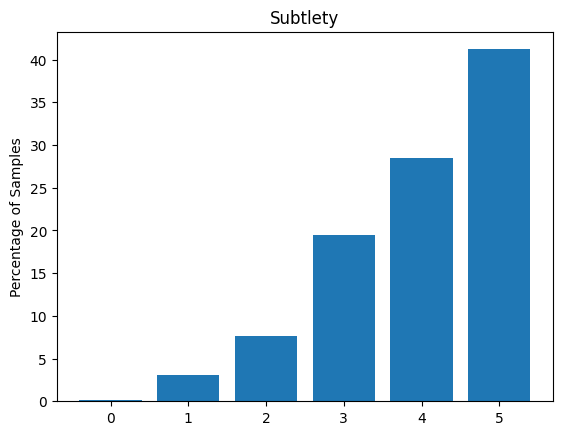

In [ ]:
#calculate the frequency percentages for 'subtlety'
subtlety_counts = df_train['subtlety'].value_counts(normalize=True) * 100

# bar plot to visualize the percentage distribution of 'subtlety'
plt.bar(subtlety_counts.index, subtlety_counts)
plt.title('Subtlety')
plt.ylabel('Percentage of Samples')
plt.savefig('Subtlety.png')
plt.show()

The subtlety of a lesion is a categorical label that indicates how difficult it is for a radiologist or a machine learning model to identify the lesion based on its appearance in the mammogram images. It is typically assigned a score to quantify the ease or difficulty of detection.

Subtlety Scale:

The subtlety is generally categorized into discrete levels, often as follows:

	•	0: No subtlety (the lesion is easily visible or well-defined).
	•	1: Slight subtlety (the lesion is still visible but may require some attention to detect).
	•	2: Moderate subtlety (the lesion is not immediately apparent and might require advanced analysis or more focused attention).
	•	3: High subtlety (the lesion is very difficult to detect and may not be immediately recognized even by experienced radiologists).

In simpler terms:

	•	Lower values (0, 1) indicate that the abnormality is easier to identify.
	•	Higher values (2, 3) suggest that the abnormality is harder to detect, making it more subtle.

## Correlation Analysis

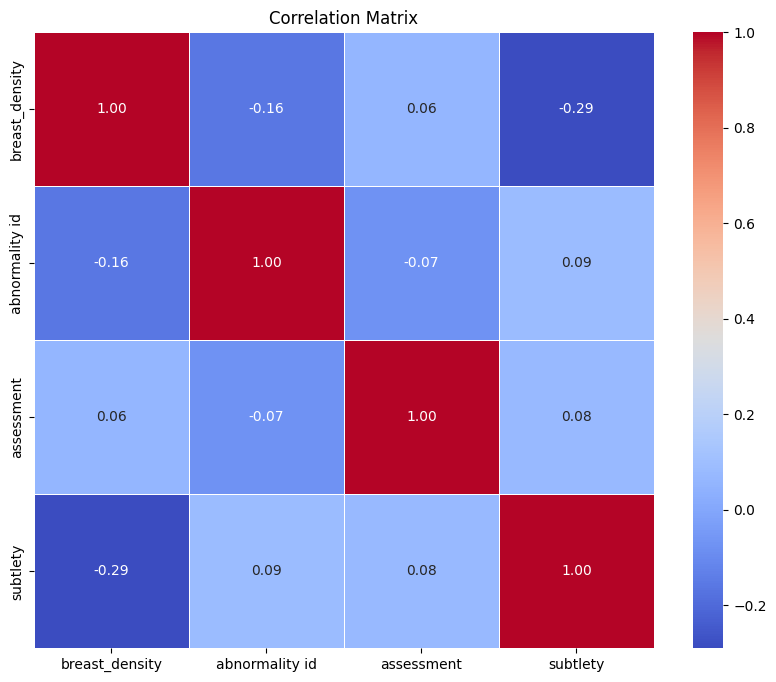

In [ ]:
#select columns with data types 'int64' and 'float64' for the analysis
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
#compute pairwise correlations between the numerical columns
correlation_matrix = df_train[numerical_cols].corr()
#visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#list of categorical columns
categorical_columns = ['image view', 'abnormality type', 'mass shape', 'mass margins', 'pathology']

#loop through each pair of categorical columns
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]

        #contingency table
        contingency_table = pd.crosstab(df_train[col1], df_train[col2])

        #Chi-Square test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"\nChi-Square Test between '{col1}' and '{col2}':")
        print(f"Chi-Square Statistic: {chi2:.2f}, P-value: {p:.4f}")

        #interpretation
        if p < 0.05:
            print("Result: Significant association")
        else:
            print("Result: No significant association")


Chi-Square Test between 'image view' and 'abnormality type':
Chi-Square Statistic: 0.00, P-value: 1.0000
Result: No significant association

Chi-Square Test between 'image view' and 'mass shape':
Chi-Square Statistic: 13.15, P-value: 0.7264
Result: No significant association

Chi-Square Test between 'image view' and 'mass margins':
Chi-Square Statistic: 7.59, P-value: 0.9095
Result: No significant association

Chi-Square Test between 'image view' and 'pathology':
Chi-Square Statistic: 4.20, P-value: 0.1223
Result: No significant association

Chi-Square Test between 'abnormality type' and 'mass shape':
Chi-Square Statistic: 0.00, P-value: 1.0000
Result: No significant association

Chi-Square Test between 'abnormality type' and 'mass margins':
Chi-Square Statistic: 0.00, P-value: 1.0000
Result: No significant association

Chi-Square Test between 'abnormality type' and 'pathology':
Chi-Square Statistic: 0.00, P-value: 1.0000
Result: No significant association

Chi-Square Test between 'ma

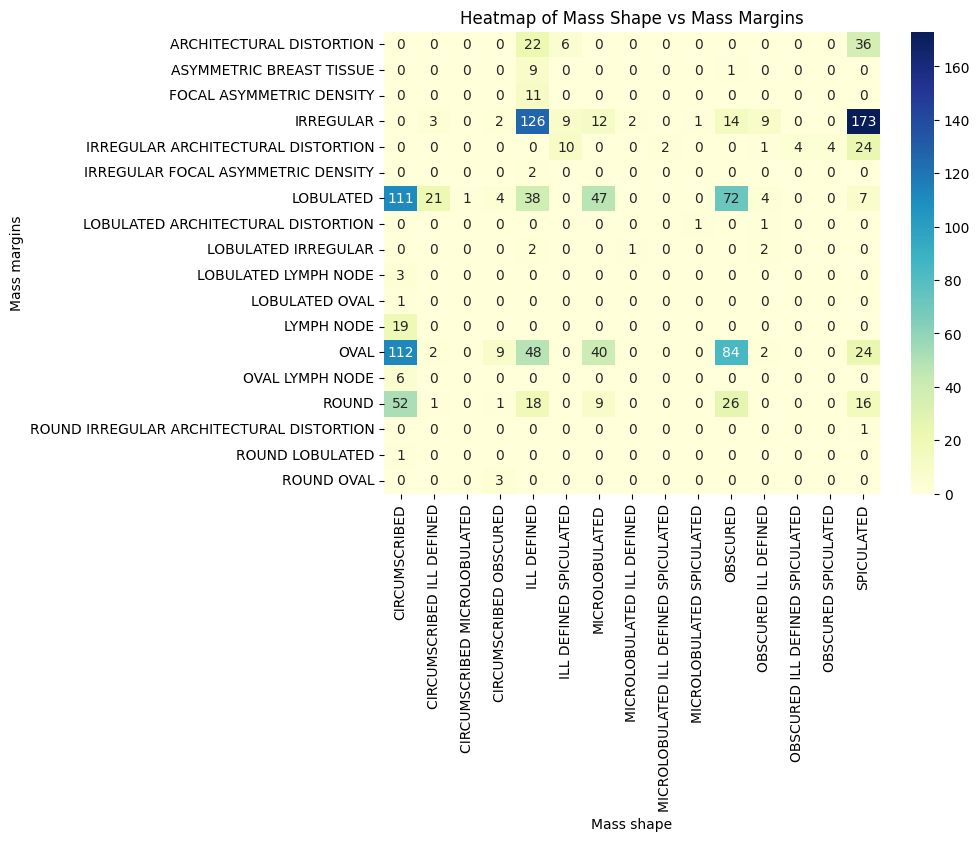

In [ ]:
#create a contingency table for 'mass shape' and 'mass margins'
contingency_table = pd.crosstab(df_train['mass shape'], df_train['mass margins'])

#visualize a the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap of Mass Shape vs Mass Margins')
plt.xlabel('Mass shape')
plt.ylabel('Mass margins')
plt.savefig('MassShapeVsMassMargins.png')
plt.show()

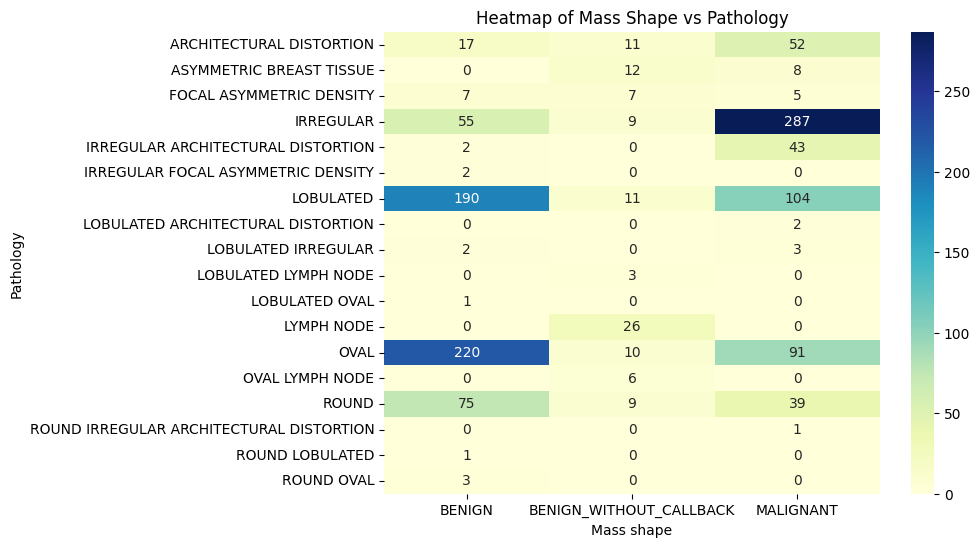

In [ ]:
#create a contingency table for 'mass shape' and 'pathology'
contingency_table = pd.crosstab(df_train['mass shape'], df_train['pathology'])

#visualize the contingency table as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap of Mass Shape vs Pathology')
plt.xlabel('Mass shape')
plt.ylabel('Pathology')
plt.savefig('MassShapeVsPathology.png')
plt.show()

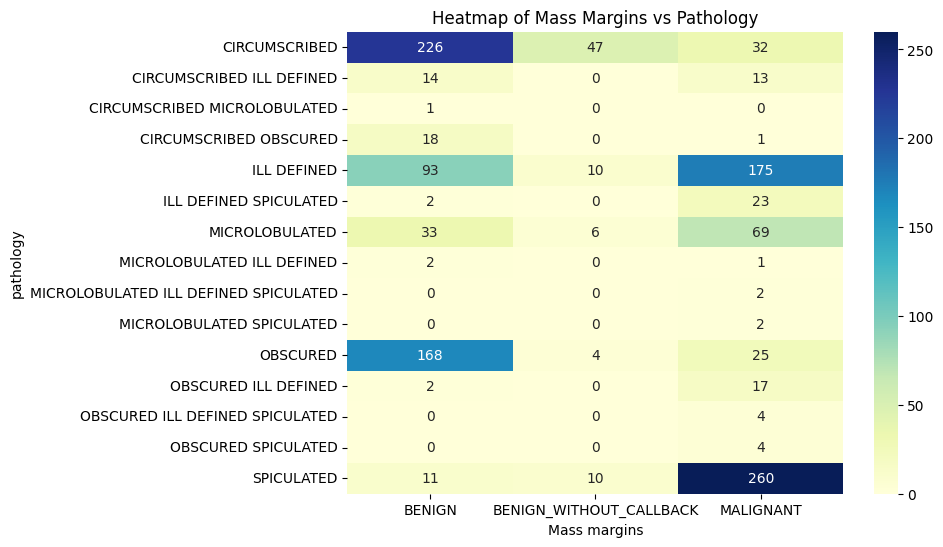

In [ ]:
#create a contingency table of for 'mass margins' and 'pathology'
contingency_table = pd.crosstab(df_train['mass margins'], df_train['pathology'])
#visualize the contingency table as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap of Mass Margins vs Pathology')
plt.xlabel('Mass margins')
plt.ylabel('pathology')
plt.savefig('MassMarginsVsPathology.png')
plt.show()

In [ ]:
df_train.groupby(['subtlety', 'pathology'])['patient_id'].count()

subtlety  pathology              
0         BENIGN                       2
1         BENIGN                      10
          BENIGN_WITHOUT_CALLBACK      1
          MALIGNANT                   30
2         BENIGN                      40
          BENIGN_WITHOUT_CALLBACK      4
          MALIGNANT                   56
3         BENIGN                     139
          BENIGN_WITHOUT_CALLBACK     17
          MALIGNANT                  101
4         BENIGN                     180
          BENIGN_WITHOUT_CALLBACK     39
          MALIGNANT                  156
5         BENIGN                     206
          BENIGN_WITHOUT_CALLBACK     43
          MALIGNANT                  294
Name: patient_id, dtype: int64

In [ ]:
df_train.groupby(['assessment', 'pathology'])['patient_id'].count()

assessment  pathology              
0           BENIGN                     110
            MALIGNANT                   19
1           MALIGNANT                    1
2           BENIGN                      28
            BENIGN_WITHOUT_CALLBACK     49
3           BENIGN                     189
            BENIGN_WITHOUT_CALLBACK     45
            MALIGNANT                   45
4           BENIGN                     246
            BENIGN_WITHOUT_CALLBACK      8
            MALIGNANT                  279
5           BENIGN                       4
            BENIGN_WITHOUT_CALLBACK      2
            MALIGNANT                  293
Name: patient_id, dtype: int64

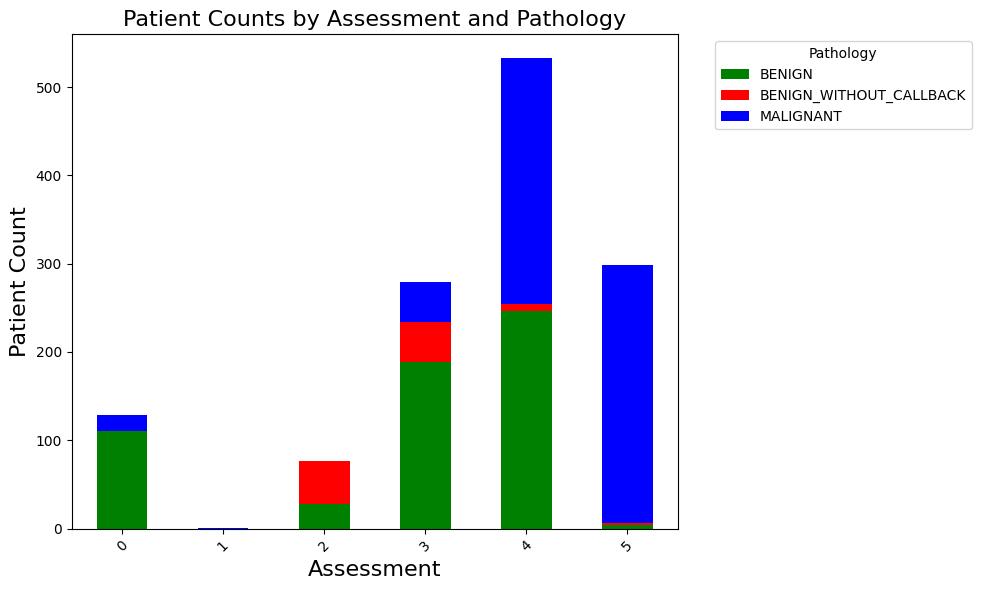

In [ ]:
#create a summary of patient counts for each combination of assessment and pathology
grouped_counts = df_train.groupby(['assessment', 'pathology'])['patient_id'].count().unstack()
#create a stacked bar plot to visualize the grouped data
grouped_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red', 'blue'])

plt.title('Patient Counts by Asessment and Pathology', fontsize=16)
plt.xlabel('Assessment', fontsize=16)
plt.ylabel('Patient Count', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Pathology', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('AssessmentVsPathology.png')
plt.show()

# Preprocessing Data

After considering our EDA, we decide to combine the following features into a single composite text feature that we feed into our model:


*   Breast Density
*   Left or Right Breast
*  Image View
*   Abnormality ID
*   Mass Shape
*   Mass Margins
*   Subtlety

Patient images labelled benign with callback were grouped into the benign category, as we are not concerned with predicting callback rates.


The script we pre-ran is given below.

In [ ]:
# this function makes a composite feature from our text data
def convert_row_to_paragraph(row):
    return (
        f"breast_density: {row['breast_density']}, "
        f"left_or_right_breast: {row['left or right breast']}, "
        f"image_view: {row['image view']}, "
        f"abnormality_id: {row['abnormality id']}, "
        f"mass_shape: {row['mass shape']}, "
        f"mass_margins: {row['mass margins']}, "
        f"subtlety: {row['subtlety']}"
    )

def create_label_column(dataframe):
    dataframe['label'] = dataframe['pathology'].apply(
        lambda x: 1 if x == 'MALIGNANT' else 0
    )
    return dataframe

# path = "/content/drive/MyDrive/DL Project/TabularData/mass_case_description_train_set.csv"
# df = pd.read_csv(path)
# df['paragraph'] = df.apply(convert_row_to_paragraph, axis=1)
# df = create_label_column(df)
# df.to_csv('/content/drive/MyDrive/DL Project/TabularData/mass_case_description_train_set.csv', index = False)

# path = "/content/drive/MyDrive/DL Project/TabularData/mass_case_description_test_set.csv"
# df = pd.read_csv(path)
# df['paragraph'] = df.apply(convert_row_to_paragraph, axis=1)
# df = create_label_column(df)
# df.to_csv('/content/drive/MyDrive/DL Project/TabularData/mass_case_description_test_set.csv', index = False)

The final saved tensors we use contain a mammogram image and the composite text feature for each patient.

## Setting Up Dataloader (with previously augmented data)

In [ ]:
class MergedMammogramDataset(Dataset):
    def __init__(self, merged_file, transform=None):
        data = torch.load(merged_file)
        self.tensors = data['tensors']
        self.metadata = data['metadata']
        self.transform = transform

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        image_tensor = self.tensors[idx]
        paragraph = self.metadata[idx]['paragraph']
        label = self.metadata[idx]['label']

        label_tensor = torch.tensor(label)

        #always apply resizing and normalization
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return paragraph, image_tensor, label_tensor


def get_dataloaders_from_full_dataset_with_grouping(
    merged_full_file,
    batch_size=32,
    num_workers=2,
    transform=None,
    train_split=0.6,
    val_split=0.2,
    test_split=0.2
):
    #load the full dataset
    full_dataset = MergedMammogramDataset(merged_full_file, transform=transform)

    #extract metadata, labels, and groups for splitting
    labels = [metadata['label'] for metadata in full_dataset.metadata]
    groups = [metadata.get('patient_id', idx) for idx, metadata in enumerate(full_dataset.metadata)]

    #group-based test split
    gss = GroupShuffleSplit(n_splits=1, test_size=test_split, random_state=42)
    train_val_indices, test_indices = next(gss.split(range(len(full_dataset.tensors)), labels, groups))

    #labels and groups for train + val split
    train_val_labels = [labels[idx] for idx in train_val_indices]
    train_val_groups = [groups[idx] for idx in train_val_indices]

    #group-based train/val split
    gss_train_val = GroupShuffleSplit(n_splits=1, test_size=val_split / (train_split + val_split), random_state=42)
    train_indices, val_indices = next(gss_train_val.split(train_val_indices, train_val_labels, train_val_groups))

    #map indices back to the original dataset
    train_indices = [train_val_indices[idx] for idx in train_indices]
    val_indices = [train_val_indices[idx] for idx in val_indices]

    #subsets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    #DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader


#basic transformation (resize and normalize only)
transform = Compose([
    Resize((256, 256)),
    Normalize(mean=[0.5], std=[0.5])
])

#get the DataLoaders without augmentation
train_loader, val_loader, test_loader = get_dataloaders_from_full_dataset_with_grouping(
    merged_full_file=train_path,
    batch_size=16,
    num_workers=2,
    transform=transform,
    train_split=0.7,
    val_split=0.2,
    test_split=0.1
)


<ipython-input-6-6f9889d5b4b0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(merged_file)


# Training and Testing Models

## Baseline Model: Image Only (Single-Modality) add dropout

### Model Architecture

In [ ]:
###############################################################
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim, dropout_rate=0.5):
        super(ResNetClassifier, self).__init__()
        #load pre-trained ResNet50
        self.base_model = resnet50(pretrained=True)

        #first convolutional layer for 1-channel input (grayscale images)
        self.base_model.conv1 = nn.Conv2d(
            in_channels=1,  #input channels=1
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # Freeze all layers in the original ResNet
        # for param in self.base_model.parameters():
        #     param.requires_grad = False

        #remove the original fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        #add hidden layers with BatchNorm, ReLU, and Dropout
        layers = []
        input_dim = num_features
        for dim in hidden_dim:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = dim

        #add final classifier layer
        self.hidden_layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim[-1], num_classes)

    def forward(self, x):
        #extract features using the frozen ResNet
        features = self.base_model(x)

        #pass through added layers
        features = self.hidden_layers(features)
        logits = self.classifier(features)
        return logits
###############################################################

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
################################################################
num_classes = 2
hidden_dim = [256, 128]
dropout_rate = 0.5
#instantiate the model
resnet_model = ResNetClassifier(num_classes=num_classes, hidden_dim=hidden_dim, dropout_rate=dropout_rate).to(device)
################################################################

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.0001, weight_decay=1e-4)

#lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}]")

    #training phase
    resnet_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

    for i, (_, images, labels) in train_bar:  #ignore the first value (paragraph)
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_bar.set_postfix({"Loss": loss.item()})

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    #validation phase
    resnet_model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0
    all_preds = []
    all_labels = []
    val_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")

    with torch.no_grad():
        for i, (_, images, labels) in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]



Epoch [1/3]


Training: 100%|██████████| 58/58 [00:12<00:00,  4.76it/s, Loss=0.829]

Epoch 1, Train Loss: 0.7131, Train Accuracy: 55.75%



Validation: 100%|██████████| 17/17 [00:00<00:00, 17.36it/s]

Validation Loss: 0.6559, Validation Accuracy: 64.39%

Epoch [2/3]



Training: 100%|██████████| 58/58 [00:10<00:00,  5.52it/s, Loss=0.461]

Epoch 2, Train Loss: 0.6265, Train Accuracy: 64.32%



Validation: 100%|██████████| 17/17 [00:00<00:00, 17.78it/s]

Validation Loss: 0.6609, Validation Accuracy: 66.67%

Epoch [3/3]



Training: 100%|██████████| 58/58 [00:10<00:00,  5.46it/s, Loss=1.02]

Epoch 3, Train Loss: 0.5313, Train Accuracy: 74.73%



Validation: 100%|██████████| 17/17 [00:00<00:00, 17.53it/s]

Validation Loss: 0.6306, Validation Accuracy: 65.15%


### Evaluation


Final Metrics on Validation Set:
Precision: 0.6667, Recall: 0.5041, F1 Score: 0.5741


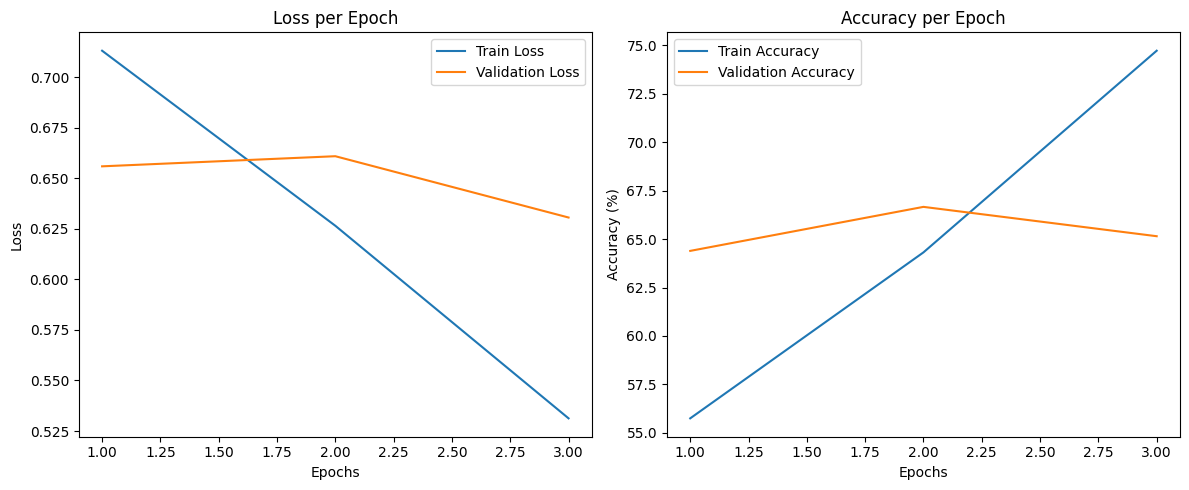

In [ ]:
#calculate precision, recall, F1 score
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print("\nFinal Metrics on Validation Set:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

#plot train/validation losses and accuracies
plt.figure(figsize=(12, 5))

#loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

#accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Saving Model

In [ ]:
# # Define a save path
# save_path = "densenet_model.pth"
# torch.save({
#     'model_state_dict': densenet_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
#     'epoch': epoch,
#     'train_losses': densenet_train_losses,
#     'val_losses': densenet_val_losses,
#     'train_accuracies': densenet_train_accuracies,
#     'val_accuracies': densenet_val_accuracies
# }, save_path)

# print(f"Model saved to {save_path}")


### Test Set Performance


Test Metrics:
Loss: 0.8048, Accuracy: 61.36%, Precision: 0.7436, Recall: 0.4143, F1 Score: 0.5321

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67        62
           1       0.74      0.41      0.53        70

    accuracy                           0.61       132
   macro avg       0.65      0.63      0.60       132
weighted avg       0.66      0.61      0.60       132



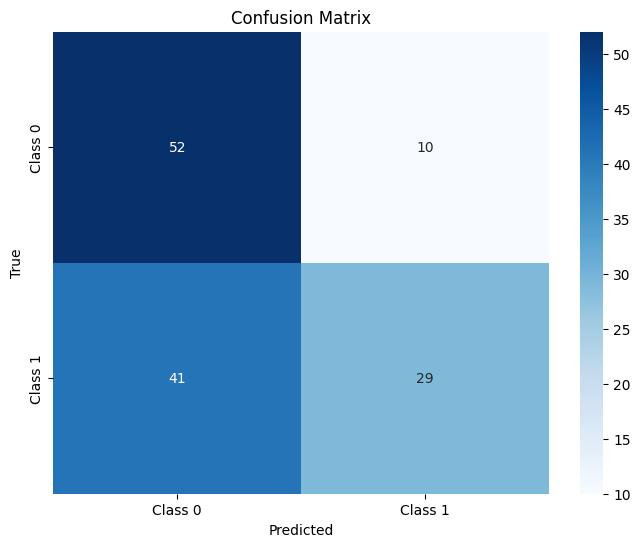

In [ ]:
def evaluate_model_on_test(loader, model, criterion, device):
    model.eval()  # model set to evaluation mode
    test_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for _, images, labels in loader:  #ignore paragraph text
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #loss
            test_loss += criterion(outputs, labels).item()

            #predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #metrics
    test_loss /= len(loader)
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\nTest Metrics:")
    print(f"Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    #classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    #confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

criterion = nn.CrossEntropyLoss()
evaluate_model_on_test(test_loader, resnet_model, criterion, device)

## Multimodal Model 1 (CLIP Encoding + Fully Connected Layers)

### Model Architecture

In [ ]:

class MultimodalCLIPModel(nn.Module):
    def __init__(self, common_embedding_dim, hidden_dim):
        super(MultimodalCLIPModel, self).__init__()
        self.text_projection = nn.Sequential(
            nn.Linear(common_embedding_dim, common_embedding_dim),
            nn.BatchNorm1d(common_embedding_dim),
            nn.ReLU(),
        )
        self.image_projection = nn.Sequential(
            nn.Linear(common_embedding_dim, common_embedding_dim),
            nn.BatchNorm1d(common_embedding_dim),
            nn.ReLU(),
        )

        #common layers to pass image and text features through
        layers = []
        input_dim = common_embedding_dim
        for dim in hidden_dim:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            input_dim = dim

        self.hidden_layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim[-1], 1)

    # firward pass
    def forward(self, text_features, image_features):
        encoded_text = self.text_projection(text_features)
        encoded_image = self.image_projection(image_features)
        # combine features
        combined_features = encoded_text + encoded_image
        combined_features = self.hidden_layers(combined_features)
        logits = self.classifier(combined_features).squeeze(-1)
        return logits


### Training

In [ ]:
def train_multimodal(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    text_encoder,
    image_encoder,
    processor,
    device,
    epochs=10
):
    #metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    precision_scores, recall_scores, f1_scores = [], [], []

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        #training phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for i, (paragraphs, images, labels) in train_bar:
            #process text features
            text_inputs = processor(text=paragraphs, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                text_features = text_encoder.get_text_features(**text_inputs)
            text_features = torch.nn.functional.normalize(text_features, dim=-1)

            #process image features
            pil_images = [ToPILImage()(image.squeeze(0)) for image in images]
            image_inputs = processor(images=pil_images, return_tensors="pt", padding=True).to(device)
            with torch.no_grad():
                image_features = image_encoder.get_image_features(**image_inputs)
            image_features = torch.nn.functional.normalize(image_features, dim=-1)

            #combine features and forward pass
            labels = labels.to(device).float()
            logits = model(text_features, image_features)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            #accuracy
            predictions = (torch.sigmoid(logits) > 0.5).long()
            total_train += labels.size(0)
            correct_train += (predictions == labels.long()).sum().item()

            train_bar.set_postfix({"Loss": loss.item()})

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Average Training Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        #validation phase
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        all_preds, all_labels = [], []
        val_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")

        with torch.no_grad():
            for i, (paragraphs, images, labels) in val_bar:
                #process text features
                text_inputs = processor(text=paragraphs, return_tensors="pt", padding=True, truncation=True).to(device)
                text_features = text_encoder.get_text_features(**text_inputs)
                text_features = torch.nn.functional.normalize(text_features, dim=-1)

                #process image features
                pil_images = [ToPILImage()(image.squeeze(0)) for image in images]
                image_inputs = processor(images=pil_images, return_tensors="pt", padding=True).to(device)
                image_features = image_encoder.get_image_features(**image_inputs)
                image_features = torch.nn.functional.normalize(image_features, dim=-1)

                #combine features and forward pass
                labels = labels.to(device).float()
                logits = model(text_features, image_features)
                val_loss += criterion(logits, labels).item()

                predictions = (torch.sigmoid(logits) > 0.5).long()
                total_val += labels.size(0)
                correct_val += (predictions == labels.long()).sum().item()

                #store predictions and labels for metrics
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        #precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        #step the scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}, Learning Rate: {current_lr:.6f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, precision_scores, recall_scores, f1_scores


In [ ]:
#CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#freeze the model's parameters
for param in clip_model.parameters():
    param.requires_grad = False

common_embedding_dim = 512  #this matches the CLIP embedding size
hidden_dim = [256, 128]
clip_multimodal_model = MultimodalCLIPModel(common_embedding_dim, hidden_dim).to(device)

#optimizer, scheduler, and loss criterion
#only the parameters of `clip_multimodal_model` are trainable
optimizer = torch.optim.AdamW(clip_multimodal_model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
criterion = nn.BCEWithLogitsLoss()

#training loop
train_losses, val_losses, train_accuracies, val_accuracies, precision_scores, recall_scores, f1_scores = train_multimodal(
    model=clip_multimodal_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    text_encoder=clip_model,
    image_encoder=clip_model,
    processor=clip_processor,
    device=device,
    epochs=5
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Epoch [1/5]



Training: 100%|██████████| 58/58 [00:07<00:00,  7.61it/s, Loss=0.489]

Epoch 1, Average Training Loss: 0.6513, Train Accuracy: 59.76%



Validation: 100%|██████████| 17/17 [00:01<00:00,  9.34it/s]

Validation Loss: 0.6975, Validation Accuracy: 46.59%
Precision: 0.4659, Recall: 1.0000, F1 Score: 0.6357
Epoch 1, Learning Rate: 0.000100

Epoch [2/5]



Training: 100%|██████████| 58/58 [00:06<00:00,  9.43it/s, Loss=0.66]

Epoch 2, Average Training Loss: 0.5167, Train Accuracy: 76.79%



Validation: 100%|██████████| 17/17 [00:01<00:00,  9.94it/s]


Validation Loss: 0.5245, Validation Accuracy: 79.55%
Precision: 0.7594, Recall: 0.8211, F1 Score: 0.7891
Epoch 2, Learning Rate: 0.000080

Epoch [3/5]


Training: 100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Loss=0.335]

Epoch 3, Average Training Loss: 0.4740, Train Accuracy: 81.24%



Validation: 100%|██████████| 17/17 [00:01<00:00,  9.79it/s]

Validation Loss: 0.5006, Validation Accuracy: 79.17%
Precision: 0.7615, Recall: 0.8049, F1 Score: 0.7826
Epoch 3, Learning Rate: 0.000080

Epoch [4/5]



Training: 100%|██████████| 58/58 [00:06<00:00,  9.54it/s, Loss=0.297]

Epoch 4, Average Training Loss: 0.4248, Train Accuracy: 82.97%



Validation: 100%|██████████| 17/17 [00:02<00:00,  8.44it/s]

Validation Loss: 0.4879, Validation Accuracy: 79.17%
Precision: 0.7698, Recall: 0.7886, F1 Score: 0.7791
Epoch 4, Learning Rate: 0.000064

Epoch [5/5]



Training: 100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Loss=0.461]

Epoch 5, Average Training Loss: 0.4180, Train Accuracy: 82.00%



Validation: 100%|██████████| 17/17 [00:01<00:00,  9.79it/s]

Validation Loss: 0.4844, Validation Accuracy: 79.55%
Precision: 0.7760, Recall: 0.7886, F1 Score: 0.7823
Epoch 5, Learning Rate: 0.000064


### Evaluation

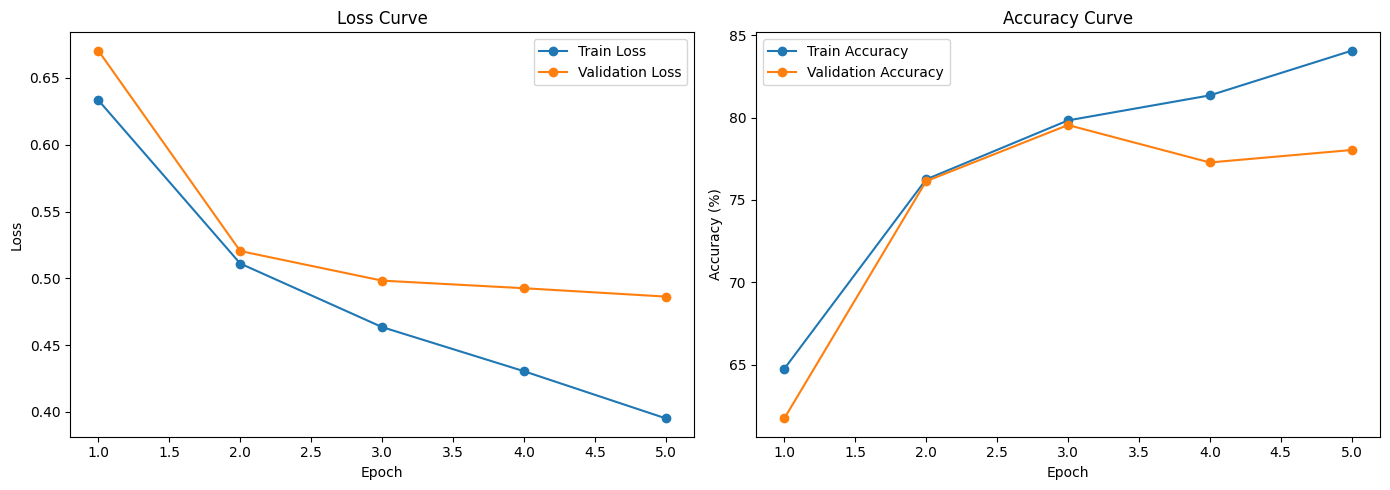

In [ ]:
epochs=5
plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

#accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


### Saving Model

In [ ]:
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, "clip_multimodal_model.pth")

# # Save the model
# torch.save({
#     'model_state_dict': clip_multimodal_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
#     'train_losses': clip_train_losses,
#     'val_losses': clip_val_losses,
#     'train_accuracies': clip_train_accuracies,
#     'val_accuracies': clip_val_accuracies
# }, model_path)

# print(f"Model saved to {model_path}")


### Testing

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  7.89it/s]



Test Metrics:
Loss: 0.3697
Precision: 0.8769, Recall: 0.8143, F1 Score: 0.8444

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84        62
         1.0       0.88      0.81      0.84        70

    accuracy                           0.84       132
   macro avg       0.84      0.84      0.84       132
weighted avg       0.84      0.84      0.84       132



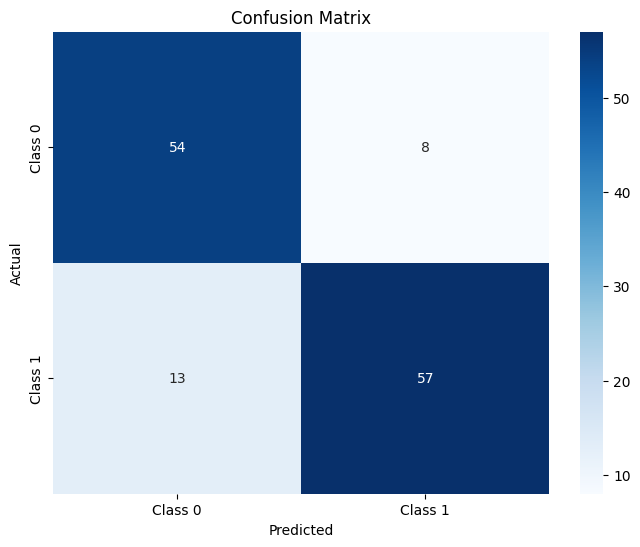

In [ ]:
def evaluate_clip_model_on_test(test_loader, model, criterion, text_encoder, image_encoder, processor, device):
    model.eval()
    test_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for paragraphs, images, labels in tqdm(test_loader, desc="Evaluating"):
            #normalize images to [0, 1] range
            images = images.float() / 255.0 if images.max() > 1 else images

            #images to PIL format
            pil_images = [ToPILImage()(image.cpu()) for image in images]

            #process text features
            text_inputs = processor(text=paragraphs, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features = text_encoder.get_text_features(**text_inputs)
            text_features = torch.nn.functional.normalize(text_features, dim=-1)

            #process image features
            image_inputs = processor(images=pil_images, return_tensors="pt").to(device)
            image_features = image_encoder.get_image_features(**image_inputs)
            image_features = torch.nn.functional.normalize(image_features, dim=-1)

            #move labels to device
            labels = labels.to(device).float()

            #forward pass
            logits = model(text_features, image_features)
            loss = criterion(logits, labels)
            test_loss += loss.item()

            #predictions
            predictions = (torch.sigmoid(logits) > 0.5).long()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\nTest Metrics:")
    print(f"Loss: {test_loss / len(test_loader):.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    #classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    #confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#evaluate the model on test set
evaluate_clip_model_on_test(test_loader, clip_multimodal_model, criterion, clip_model, clip_model, clip_processor, device)

## Multimodal Model 2 (BERT Text Encoder + ResNet Image Encoder + Fully Connected Layers)

### Model Architecture

In [ ]:
class ResNetMultimodalModel(nn.Module):
    def __init__(self, text_embedding_dim, image_embedding_dim, common_embedding_dim, hidden_dims):
        super(ResNetMultimodalModel, self).__init__()
        #text encoder: BERT
        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")

        #image encoder: ResNet50
        resnet_model = models.resnet50(pretrained=True)
        resnet_model.conv1 = nn.Conv2d(
            in_channels=1,  #input channels=1 for grayscale images
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        self.image_encoder = nn.Sequential(
            resnet_model,
            nn.Linear(1000, image_embedding_dim),
            nn.ReLU()
        )

        #common layers for both encoders
        self.common_text_layer = nn.Sequential(
            nn.Linear(text_embedding_dim, common_embedding_dim),
            nn.BatchNorm1d(common_embedding_dim),
            nn.ReLU()
        )
        self.common_image_layer = nn.Sequential(
            nn.Linear(image_embedding_dim, common_embedding_dim),
            nn.BatchNorm1d(common_embedding_dim),
            nn.ReLU()
        )

        #hidden layers
        layers = []
        input_dim = common_embedding_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            input_dim = hidden_dim

        self.hidden_layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dims[-1], 1)

    def forward(self, input_ids, attention_mask, images):
        #encode text
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = self.common_text_layer(text_features)

        #encode images
        image_features = self.image_encoder(images)
        image_features = self.common_image_layer(image_features)

        #combine features
        combined_features = image_features + text_features

        #pass through hidden layers and classifier
        hidden_output = self.hidden_layers(combined_features)
        logits = self.classifier(hidden_output).squeeze(-1)
        return logits

### Training

In [ ]:
def train_with_validation(
    model, train_loader, val_loader, optimizer, criterion, device, tokenizer, num_epochs, scheduler
):
    metrics = {
        "resnet_train_loss": [], "resnet_train_accuracy": [], "resnet_train_precision": [], "resnet_train_recall": [], "resnet_train_f1": [],
        "resnet_val_loss": [], "resnet_val_accuracy": [], "resnet_val_precision": [], "resnet_val_recall": [], "resnet_val_f1": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        #training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train_samples = 0
        train_predictions = []
        train_labels = []
        train_bar = tqdm(train_loader, desc="Training")

        for paragraphs, images, labels in train_bar:
            labels = labels.to(device).float()
            inputs = tokenizer(paragraphs, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)
            images = images.to(device)

            logits = model(input_ids, attention_mask, images)
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predictions = (torch.sigmoid(logits) > 0.5).long()
            train_predictions.append(predictions)
            train_labels.append(labels.long())
            correct_train += (predictions == labels.long()).sum().item()
            total_train_samples += labels.size(0)

            train_bar.set_postfix({"Loss": loss.item()})

        #training metrics
        train_predictions = torch.cat(train_predictions).cpu().numpy()
        train_labels = torch.cat(train_labels).cpu().numpy()
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1 = f1_score(train_labels, train_predictions)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train_samples

        metrics["resnet_train_loss"].append(avg_train_loss)
        metrics["resnet_train_accuracy"].append(train_accuracy)
        metrics["resnet_train_precision"].append(train_precision)
        metrics["resnet_train_recall"].append(train_recall)
        metrics["resnet_train_f1"].append(train_f1)

        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        #validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val_samples = 0
        val_predictions = []
        val_labels = []
        val_bar = tqdm(val_loader, desc="Validation")

        with torch.no_grad():
            for paragraphs, images, labels in val_bar:
                labels = labels.to(device).float()
                inputs = tokenizer(paragraphs, return_tensors="pt", padding=True, truncation=True, max_length=512)
                input_ids = inputs["input_ids"].to(device)
                attention_mask = inputs["attention_mask"].to(device)
                images = images.to(device)

                logits = model(input_ids, attention_mask, images)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                predictions = (torch.sigmoid(logits) > 0.5).long()
                val_predictions.append(predictions)
                val_labels.append(labels.long())
                correct_val += (predictions == labels.long()).sum().item()
                total_val_samples += labels.size(0)

        #validation metrics
        val_predictions = torch.cat(val_predictions).cpu().numpy()
        val_labels = torch.cat(val_labels).cpu().numpy()
        val_precision = precision_score(val_labels, val_predictions)
        val_recall = recall_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val_samples

        metrics["resnet_val_loss"].append(avg_val_loss)
        metrics["resnet_val_accuracy"].append(val_accuracy)
        metrics["resnet_val_precision"].append(val_precision)
        metrics["resnet_val_recall"].append(val_recall)
        metrics["resnet_val_f1"].append(val_f1)

        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        scheduler.step()

    return metrics


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

text_embedding_dim = 768  #BERT embedding dimension
image_embedding_dim = 1000  #ResNet reduced dimension
common_embedding_dim = 256
hidden_dim = [512, 256]

resnet_multimodal_model = ResNetMultimodalModel(text_embedding_dim, image_embedding_dim, common_embedding_dim, hidden_dim).to(device)
optimizer = optim.AdamW([
    {"params": resnet_multimodal_model.text_encoder.parameters(), "lr": 1e-6},  #Smaller learning rate for BERT
    {"params": resnet_multimodal_model.image_encoder[0].parameters(), "lr": 1e-6},  #Smaller learning rate for ResNet
    {"params": resnet_multimodal_model.hidden_layers.parameters(), "lr": 1e-3},  #Larger learning rate for custom layers
    {"params": resnet_multimodal_model.classifier.parameters(), "lr": 1e-3}
], weight_decay=1e-3)

scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=len(train_loader) * 6,  #number of updates
    eta_min=1e-6  #minimum learning rate
)
criterion = nn.BCEWithLogitsLoss()

#train
metrics = train_with_validation(resnet_multimodal_model, train_loader, val_loader, optimizer, criterion, device, tokenizer, num_epochs=6, scheduler=scheduler)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/6]


Training: 100%|██████████| 58/58 [00:22<00:00,  2.59it/s, Loss=0.826]


Train Loss: 0.7183, Accuracy: 0.5249


Validation: 100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


Val Loss: 0.6407, Accuracy: 0.6477

Epoch [2/6]


Training: 100%|██████████| 58/58 [00:22<00:00,  2.54it/s, Loss=0.685]


Train Loss: 0.6693, Accuracy: 0.6041


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.10it/s]


Val Loss: 0.6032, Accuracy: 0.6477

Epoch [3/6]


Training: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s, Loss=0.401]


Train Loss: 0.6127, Accuracy: 0.6833


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


Val Loss: 0.5661, Accuracy: 0.7311

Epoch [4/6]


Training: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s, Loss=0.494]


Train Loss: 0.5260, Accuracy: 0.7332


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


Val Loss: 0.5256, Accuracy: 0.7311

Epoch [5/6]


Training: 100%|██████████| 58/58 [00:22<00:00,  2.58it/s, Loss=0.306]


Train Loss: 0.4746, Accuracy: 0.7842


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


Val Loss: 0.5356, Accuracy: 0.7765

Epoch [6/6]


Training: 100%|██████████| 58/58 [00:22<00:00,  2.59it/s, Loss=0.235]


Train Loss: 0.4223, Accuracy: 0.8102


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.13it/s]

Val Loss: 0.5109, Accuracy: 0.7917


### Evaluation

In [ ]:
#final validation precision, recall, and F1-score
val_precision = metrics["resnet_val_precision"][-1]
val_recall = metrics["resnet_val_recall"][-1]
val_f1 = metrics["resnet_val_f1"][-1]

print("\nFinal Validation Metrics:")
print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")


Final Validation Metrics:
Precision: 0.8269, Recall: 0.6992, F1 Score: 0.7577


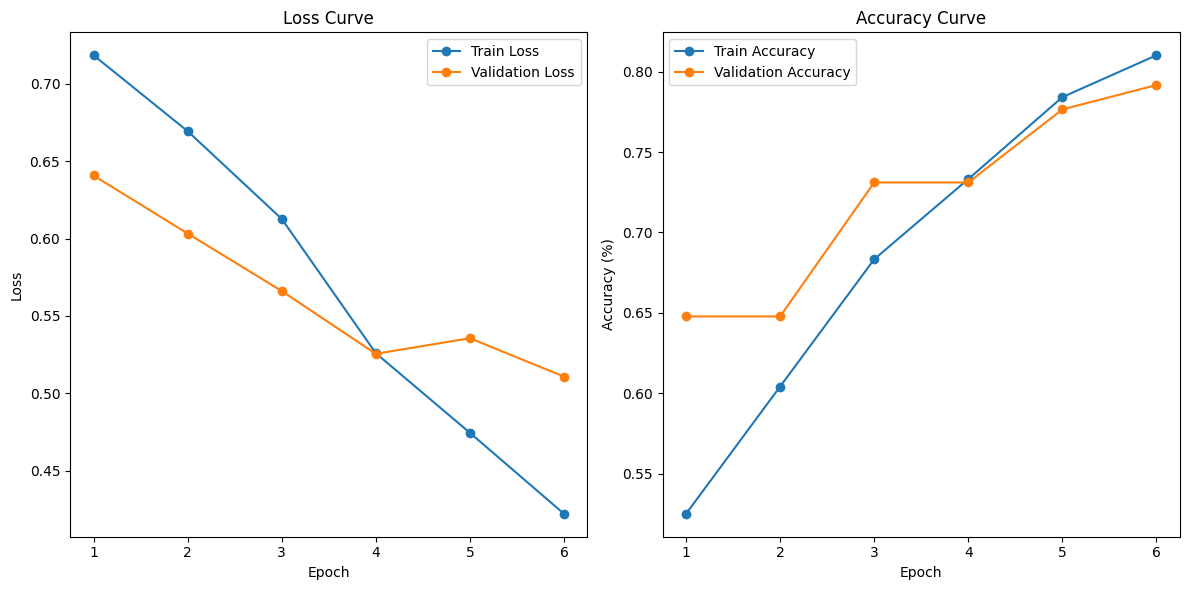

In [ ]:
#training and validation loss and accuracy curves
plt.figure(figsize=(12, 6))

#loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(metrics["resnet_train_loss"]) + 1), metrics["resnet_train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(metrics["resnet_val_loss"]) + 1), metrics["resnet_val_loss"], label="Validation Loss", marker='o')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(metrics["resnet_train_accuracy"]) + 1), metrics["resnet_train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(metrics["resnet_val_accuracy"]) + 1), metrics["resnet_val_accuracy"], label="Validation Accuracy", marker='o')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


### Saving Model

In [ ]:
# # Save model state including optimizer and scheduler
# save_path = "resnet_multimodal_model_full_state.pth"
# torch.save({
#     'model_state_dict': resnet_multimodal_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
#     'model_architecture': {
#         'text_embedding_dim': 768,
#         'image_embedding_dim': 1024,
#         'common_embedding_dim': 256,
#         'hidden_dims': [256, 128]
#     }
# }, save_path)

# print(f"Model and optimizer states saved to {save_path}")


### Testing

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  7.74it/s]



Test Metrics:
Loss: 0.4535, Accuracy: 79.55%, Precision: 0.8644, Recall: 0.7286, F1 Score: 0.7907

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80        62
         1.0       0.86      0.73      0.79        70

    accuracy                           0.80       132
   macro avg       0.80      0.80      0.80       132
weighted avg       0.81      0.80      0.80       132



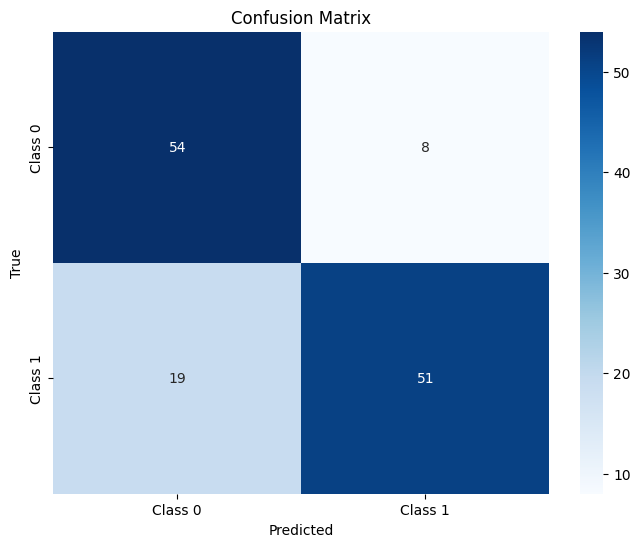

In [ ]:
def eval_resnet_multimodal_testset(loader, model, criterion, device):
    model.eval()  #model=evaluation mode
    test_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for paragraphs, images, labels in tqdm(loader, desc="Evaluating"):
            #move data to device
            paragraphs, images, labels = paragraphs, images.to(device), labels.to(device)

            #convert labels to float
            labels = labels.float()

            #text processing
            inputs = tokenizer(paragraphs, return_tensors="pt", padding=True, truncation=True).to(device)
            input_ids = inputs["input_ids"]
            attention_mask = inputs["attention_mask"]

            #forward pass
            logits = model(input_ids, attention_mask, images)

            #calculate loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            #predictions
            predictions = (torch.sigmoid(logits) > 0.5).long()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            #metrics
            correct += (predictions == labels.long()).sum().item()
            total += labels.size(0)

    #test metrics
    accuracy = 100 * correct / total
    test_loss /= len(loader)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    #test results
    print("\nTest Metrics:")
    print(f"Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    #classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    #confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

#evaluate the model
eval_resnet_multimodal_testset(test_loader, resnet_multimodal_model, criterion, device)

## Multimodal Model 3 (BERT Text Encoder + Vision Transformer + Fully Connected Layers)

### Model Architecture

In [ ]:
class BertViTHybridModel(nn.Module):
    def __init__(self, text_embedding_dim, image_embedding_dim, common_embedding_dim, hidden_dims):
        super(BertViTHybridModel, self).__init__()

        #common layers for both encoders
        self.common_text_layer = nn.Sequential(
            nn.Linear(text_embedding_dim, common_embedding_dim),
            nn.BatchNorm1d(common_embedding_dim),
            nn.ReLU()
        )
        self.common_image_layer = nn.Sequential(
            nn.Linear(image_embedding_dim, common_embedding_dim),
            nn.BatchNorm1d(common_embedding_dim),
            nn.ReLU()
        )

        #hidden layers
        layers = []
        input_dim = 2 * common_embedding_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            input_dim = hidden_dim

        self.hidden_layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dims[-1], 1)

    def forward(self, text_features, image_features):
        #pass through common layers
        text_features = self.common_text_layer(text_features)
        image_features = self.common_image_layer(image_features)

        #concatenate and pass through hidden layers
        combined_features = torch.cat([text_features, image_features], dim=1)
        hidden_output = self.hidden_layers(combined_features)

        #classification layer
        logits = self.classifier(hidden_output).squeeze(-1)
        return logits


### Training

In [ ]:
def get_text_features(paragraphs, text_encoder, processor, device, encoder_type="clip"):
    inputs = processor(paragraphs, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_encoder(**inputs)
        text_features = outputs.last_hidden_state.mean(dim=1)  #mean pooling

    return torch.nn.functional.normalize(text_features, dim=-1)


def get_image_features(images, image_encoder, processor, device, encoder_type="clip"):
    #normalize images to [0, 1] range
    images = images.float() / 255.0 if images.max() > 1 else images
    #convert grayscale Tensor to 3-channel (RGB)
    images = images.repeat(1, 3, 1, 1) if images.shape[1] == 1 else images
    pil_images = [ToPILImage()(image.squeeze(0)) for image in images]
    inputs = processor(images=pil_images, return_tensors="pt").to(device)

    #move the image encoder to the device before inference:
    image_encoder = image_encoder.to(device)

    with torch.no_grad():
        outputs = image_encoder(**inputs)
        #mean pooling
        image_features = outputs.last_hidden_state.mean(dim=1)

    return torch.nn.functional.normalize(image_features, dim=-1)

In [ ]:
def train_bert_vit_hybrid(
    model, train_loader, val_loader, optimizer, criterion, device,
    text_encoder, image_encoder, text_processor, image_processor,
    text_encoder_type="bert", image_encoder_type="vit",
    num_epochs=15, scheduler=None
):
    metrics = {
        "train_loss": [], "train_accuracy": [], "train_precision": [], "train_recall": [], "train_f1": [],
        "val_loss": [], "val_accuracy": [], "val_precision": [], "val_recall": [], "val_f1": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        #training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train_samples = 0
        train_predictions = []
        train_labels = []

        for paragraphs, images, labels in tqdm(train_loader, desc="Training"):
            #get text and image features
            text_features = get_text_features(paragraphs, text_encoder, text_processor, device, text_encoder_type)
            image_features = get_image_features(images, image_encoder, image_processor, device, image_encoder_type)
            labels = labels.to(device).float()

            #forward pass
            logits = model(text_features, image_features)
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #metrics
            predictions = (torch.sigmoid(logits) > 0.5).long()
            train_predictions.append(predictions)
            train_labels.append(labels.long())
            correct_train += (predictions == labels.long()).sum().item()
            total_train_samples += labels.size(0)

        #training metrics
        train_predictions = torch.cat(train_predictions).cpu().numpy()
        train_labels = torch.cat(train_labels).cpu().numpy()
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1 = f1_score(train_labels, train_predictions)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train_samples

        metrics["train_loss"].append(avg_train_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["train_precision"].append(train_precision)
        metrics["train_recall"].append(train_recall)
        metrics["train_f1"].append(train_f1)

        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")

        #validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val_samples = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for paragraphs, images, labels in tqdm(val_loader, desc="Validation"):
                #get text and image features
                text_features = get_text_features(paragraphs, text_encoder, text_processor, device, text_encoder_type)
                image_features = get_image_features(images, image_encoder, image_processor, device, image_encoder_type)
                labels = labels.to(device).float()

                #forward pass
                logits = model(text_features, image_features)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                #metrics
                predictions = (torch.sigmoid(logits) > 0.5).long()
                val_predictions.append(predictions)
                val_labels.append(labels.long())
                correct_val += (predictions == labels.long()).sum().item()
                total_val_samples += labels.size(0)

        #validation metrics
        val_predictions = torch.cat(val_predictions).cpu().numpy()
        val_labels = torch.cat(val_labels).cpu().numpy()
        val_precision = precision_score(val_labels, val_predictions)
        val_recall = recall_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val_samples

        metrics["val_loss"].append(avg_val_loss)
        metrics["val_accuracy"].append(val_accuracy)
        metrics["val_precision"].append(val_precision)
        metrics["val_recall"].append(val_recall)
        metrics["val_f1"].append(val_f1)

        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        if scheduler:
            scheduler.step()

    return metrics


In [ ]:
#pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#pre-trained ViT model and processor
vit_processor = AutoImageProcessor.from_pretrained("google/vit-hybrid-base-bit-384")
vit_model = ViTHybridModel.from_pretrained("google/vit-hybrid-base-bit-384").to(device)
text_embedding_dim = 768  #BERT embedding size
image_embedding_dim = 768  #ViT embedding size
common_embedding_dim = 256
hidden_dims = [512, 256]

vit_multimodal_model = BertViTHybridModel(
    text_embedding_dim=text_embedding_dim,
    image_embedding_dim=image_embedding_dim,
    common_embedding_dim=common_embedding_dim,
    hidden_dims=hidden_dims
).to(device)

num_epochs = 5
#optimizer, criterion, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(vit_multimodal_model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * num_epochs, eta_min=1e-6)

metrics = train_bert_vit_hybrid(
    model=vit_multimodal_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    text_encoder=bert_model,  #BERT model
    image_encoder=vit_model,  #ViT Hybrid model
    text_processor=bert_tokenizer,  #BERT tokenizer
    image_processor=vit_processor,  #ViT processor
    text_encoder_type="bert",
    image_encoder_type="vit",
    num_epochs=num_epochs,
    scheduler=scheduler
)



Some weights of ViTHybridModel were not initialized from the model checkpoint at google/vit-hybrid-base-bit-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch [1/5]


Training: 100%|██████████| 58/58 [00:47<00:00,  1.22it/s]


Train Loss: 0.6379, Accuracy: 0.6388, Precision: 0.7734, Recall: 0.3536, F1: 0.4853


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Val Loss: 0.6773, Accuracy: 0.5720, Precision: 0.5214, Recall: 0.9919, F1: 0.6835

Epoch [2/5]


Training: 100%|██████████| 58/58 [00:46<00:00,  1.25it/s]


Train Loss: 0.4793, Accuracy: 0.7842, Precision: 0.8267, Recall: 0.6982, F1: 0.7570


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


Val Loss: 0.4946, Accuracy: 0.7841, Precision: 0.7845, Recall: 0.7398, F1: 0.7615

Epoch [3/5]


Training: 100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


Train Loss: 0.4010, Accuracy: 0.8167, Precision: 0.8176, Recall: 0.7973, F1: 0.8073


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Val Loss: 0.4668, Accuracy: 0.7917, Precision: 0.7787, Recall: 0.7724, F1: 0.7755

Epoch [4/5]


Training: 100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


Train Loss: 0.3683, Accuracy: 0.8633, Precision: 0.8630, Recall: 0.8514, F1: 0.8571


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Val Loss: 0.4498, Accuracy: 0.8030, Precision: 0.7752, Recall: 0.8130, F1: 0.7937

Epoch [5/5]


Training: 100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


Train Loss: 0.3520, Accuracy: 0.8579, Precision: 0.8455, Recall: 0.8626, F1: 0.8540


Validation: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

Val Loss: 0.4449, Accuracy: 0.8144, Precision: 0.7937, Recall: 0.8130, F1: 0.8032


### Evaluation

In [ ]:
val_precision = metrics["val_precision"][-1]
val_recall = metrics["val_recall"][-1]
val_f1 = metrics["val_f1"][-1]

print("\nFinal Validation Metrics:")
print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")


Final Validation Metrics:
Precision: 0.7937, Recall: 0.8130, F1 Score: 0.8032


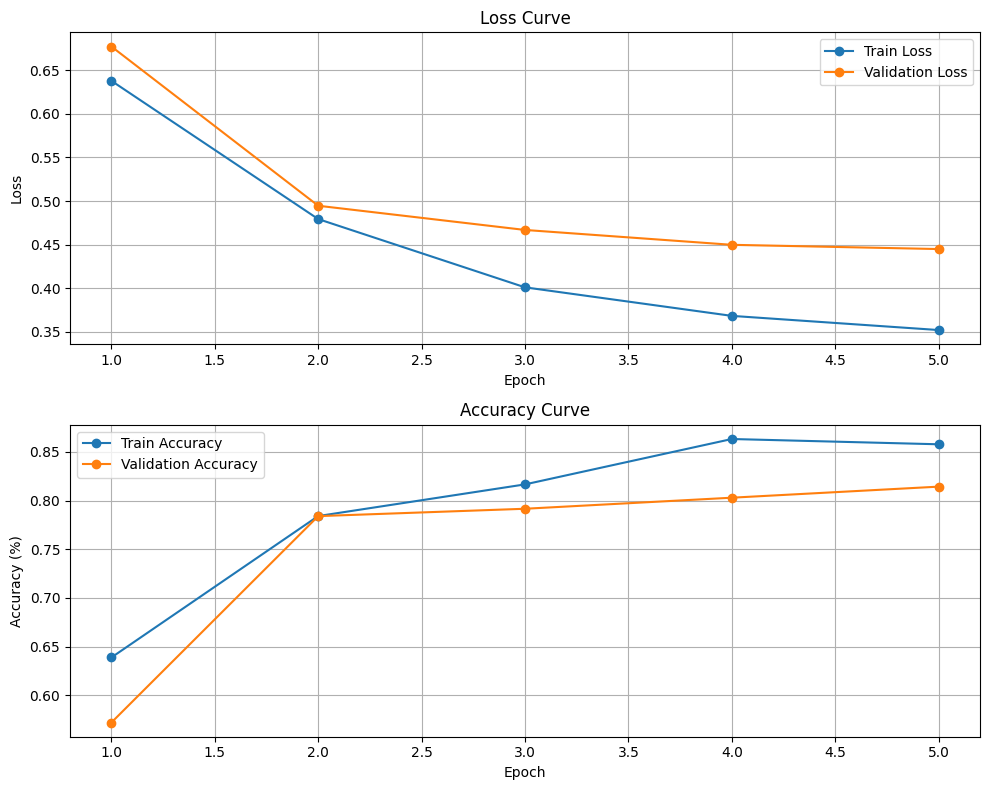

In [ ]:
#training and validation loss and accuracy curves
plt.figure(figsize=(10, 8))

#loss Curve
plt.subplot(2, 1, 1)
plt.plot(range(1, len(metrics["train_loss"]) + 1), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(metrics["val_loss"]) + 1), metrics["val_loss"], label="Validation Loss", marker='o')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

#accuracy Curve
plt.subplot(2, 1, 2)
plt.plot(range(1, len(metrics["train_accuracy"]) + 1), metrics["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(metrics["val_accuracy"]) + 1), metrics["val_accuracy"], label="Validation Accuracy", marker='o')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Saving/Loading Model

In [ ]:
# # Save model state including optimizer and scheduler
# save_path = "bert_vit_hybrid_model_full_state.pth"
# torch.save({
#     'model_state_dict': vit_multimodal_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
#     'model_architecture': {
#         'text_embedding_dim': 768,
#         'image_embedding_dim': 768,
#         'common_embedding_dim': 512,
#         'hidden_dims': [256, 128]
#     },
#     'epoch': num_epochs,
#     'metrics': metrics
# }, save_path)

# print(f"Model and optimizer states saved to {save_path}")


Model and optimizer states saved to bert_vit_hybrid_model_full_state.pth


### Testing

Evaluating: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]



Test Metrics:
Loss: 0.3448, Accuracy: 86.36%
Precision: 0.8514, Recall: 0.9000, F1 Score: 0.8750

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85        62
         1.0       0.85      0.90      0.88        70

    accuracy                           0.86       132
   macro avg       0.87      0.86      0.86       132
weighted avg       0.86      0.86      0.86       132



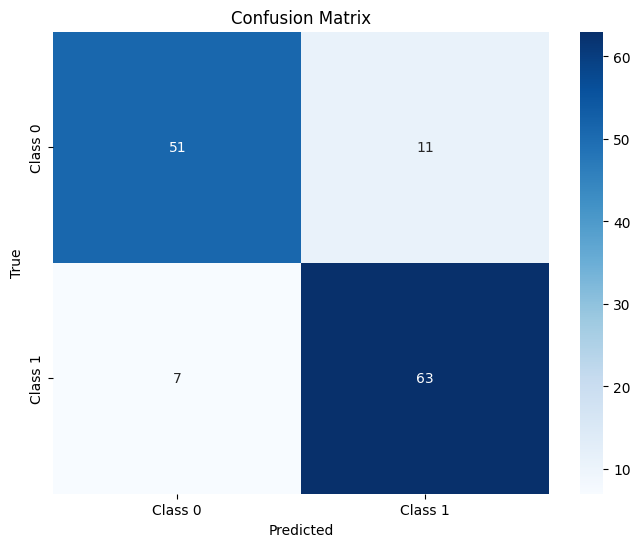

In [ ]:
def evaluate_vit_bert_model_on_test(test_loader, model, text_encoder, image_encoder, text_processor, image_processor, criterion, device):
    model.eval()  #model to evaluation mode
    total_test_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for paragraphs, images, labels in tqdm(test_loader, desc="Evaluating"):
            #get text and image features
            text_features = get_text_features(paragraphs, text_encoder, text_processor, device, encoder_type="bert")
            image_features = get_image_features(images, image_encoder, image_processor, device, encoder_type="vit")

            #forward pass through the model
            labels = labels.to(device).float()
            logits = model(text_features, image_features)

            #calculate loss
            loss = criterion(logits, labels)
            total_test_loss += loss.item()

            #predictions
            predictions = (torch.sigmoid(logits) > 0.5).long()
            total += labels.size(0)
            correct += (predictions == labels.long()).sum().item()

            #store predictions and labels for metrics
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\nTest Metrics:")
    print(f"Loss: {total_test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    #classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    #confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
evaluate_vit_bert_model_on_test(
    test_loader=test_loader,
    model=vit_multimodal_model,
    text_encoder=bert_model,
    image_encoder=vit_model,
    text_processor=bert_tokenizer,
    image_processor=vit_processor,
    criterion=criterion,
    device=device
)